# ResNet for CIFAR-10 
**based on Section 4.2 in "Deep Residual Learning for Image Recognition" from Kaiming He, Xiangyu Zhang, Shaoqing Ren and Jian Sun**
(https://arxiv.org/abs/1512.03385)

 **Google Colab Setup**

(Skip the next two cells, if you don't use colab)

In [2]:
# for using the Google Colaboratory
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Check GPU RAM usage in Google Colab
# from: https://gist.github.com/okomarov/c0d9fd0718f6f9b40c701e61523dfed1
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp37-none-any.whl size=7411 sha256=7422c8f4c66ee7adabbfa5f87ac7000599cc9a134c3521d9aa440311595a97bd
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.8 GB  |     Proc size: 118.5 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total     11441MB


 **ResNet Implementation**

The ResNet architecture is implemented in `ResNet.py`.


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F

import matplotlib.pyplot as plt 
%matplotlib inline
import numpy as np

In [5]:
# use GPU if available
USE_GPU = True
dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else: 
    device = torch.device('cpu')
print('using device:', device)

using device: cuda


In [7]:
# Check basic functionality of architecture
from ResNet import ResNet, ResidualBlocks, ConvBlock

def test_ResNet():
    n = 1
    x = torch.zeros((64, 3, 32, 32), dtype=dtype) # minibatch size 64
    x = x.to(device)
    model = ResNet(n)
    model.to(device)
    print(model)
    scores = model(x)
    print(scores.size())
    
test_ResNet()

ResNet(
  (initial_layer): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layerBlock1): ResidualBlocks(
    (blocks): Sequential(
      (0): ConvBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (layerBlock2): ResidualBlocks(
    (blocks): Sequential(
      (0): ConvBlock(
        (max): MaxPool2d(kernel_size=1, stride=2, padding=0, dilation=1, ceil_mode=False)
        (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2):

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [8]:
# import CIFAR data and perform data augmentation

NUM_TRAIN = 45000
batch_size = 128

normalize = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

augment = T.Compose([
                T.RandomHorizontalFlip(),
                T.RandomCrop(32, padding=4)
            ])


cifar10_train = dset.CIFAR10('./cs231n/datasets', train=True, download=True, transform=T.Compose([augment, normalize]))
loader_train = DataLoader(cifar10_train, batch_size=batch_size, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = dset.CIFAR10('./cs231n/datasets', train=True, download=True, transform=normalize)
loader_val = DataLoader(cifar10_val, batch_size=batch_size, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar10_test = dset.CIFAR10('./cs231n/datasets', train=False, download=True, transform=normalize)
loader_test = DataLoader(cifar10_test, batch_size=batch_size)


Extracting ./cs231n/datasets/cifar-10-python.tar.gz to ./cs231n/datasets
Files already downloaded and verified
Files already downloaded and verified


In [9]:
#def check_accuracy(loader, model):
#    if loader.dataset.train:
#        print('Checking accuracy on validation set')
#    else: 
#        print('Checking accuracy on test set')
#    num_correct = 0
#    num_samples = 0
#    model.eval() # set model to evaluation mode
#    with torch.no_grad():
#        for x, y in loader:
#            x = x.to(device=device, dtype=dtype) # move to device, e.g. GPU
#            y = y.to(device=device, dtype=torch.long)
#            scores = model(x)
#            _, preds = scores.max(1)
#            num_correct += (y == preds).sum()
#            num_samples += preds.size(0)
#        acc = float(num_correct) / num_samples
#        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        
        
def check_accuracy_batch(scores, labels, verbose=False):
    _, preds = scores.max(1)
    num_correct = (labels == preds).sum()
    num_samples = preds.size(0)
    acc = float(num_correct) / num_samples
    if verbose:
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc

In [10]:
# training and validation function for one epoch

def train_ResNet(model, optimizer, dataloader):
    """
    Train a model on CIFAR-10.
    
    Inputs:
    - model: (torch.nn.Module) A PyTorch module giving the model to train.
    - optimizer: (torch.optim) An optimizer object we will use to train the model
    - dataloader: (DataLoader) A DataLoader object supplying the training data
    
    Returns: 
    - loss_history
    - accuracy_history
    """
    # set model to training mode
    model.train()
    
    # loss history 
    loss_history = []
    accuracy_history = []
    iterations_per_epoch = max(NUM_TRAIN / batch_size, 1)

    for it, (data_batch, labels_batch) in enumerate(dataloader):

        data_batch = data_batch.to(device=device, dtype=dtype)
        labels_batch = labels_batch.to(device=device, dtype=torch.long)
        verbose = False
        if it % 10 == 0:
            verbose = True
        
        # compute scores and loss
        scores = model(data_batch)
        loss = F.cross_entropy(scores, labels_batch)
        loss_history.append(loss)
        

        if it % iterations_per_epoch == 0:
              # Check accuracy
              accuracy = check_accuracy_batch(scores, labels_batch, verbose=verbose)
              accuracy_history.append(accuracy)

        
    
        # clear previous gradients
        optimizer.zero_grad()
        
        # build gradient computational graph
        loss.backward()
        
        # actual backprop und updating params
        optimizer.step()
        
    return {
        'loss_history': loss_history, 
        'accuracy_history': accuracy_history
        }
    
    
    
    
def evaluate_ResNet(model, dataloader):
    """
    Evaluate a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: (torch.nn.Module) A PyTorch module giving the model to train.
    - dataloader: (DataLoader) A DataLoader object supplying the training data
    
    Returns: 
    - loss_history
    - accuracy_history
    """
    # set model to evaluation mode
    model.eval()
    
    # loss history 
    loss_history = []
    accuracy_history = []
    iterations_per_epoch = max(NUM_TRAIN / batch_size, 1)
    if dataloader.dataset.train == True:
      print("Evaluating accuracies on validation set")
    else:
      print("Evaluating accuracies on test set")
    
    with torch.no_grad():
      for it, (data_batch, labels_batch) in enumerate(dataloader):
        data_batch = data_batch.to(device=device, dtype=dtype)
        labels_batch = labels_batch.to(device=device, dtype=torch.long)
        verbose = False
        if it % 10 == 0:
            verbose = True
        
        # compute scores and loss
        scores = model(data_batch)
        loss = F.cross_entropy(scores, labels_batch)
        loss_history.append(loss)

        if it % iterations_per_epoch == 0:
              # Check accuracy
              accuracy = check_accuracy_batch(scores, labels_batch, verbose=verbose)
              accuracy_history.append(accuracy)
        
    return {
        'loss_history': loss_history, 
        'accuracy_history': accuracy_history
        }


In [11]:
# Train for 5 epochs
epochs = 5
n = 3
lr = 0.1
model = ResNet(n)
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0.0001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.95)
overall_train_loss, overall_val_loss, overall_train_acc, overall_val_acc = [], [], [], []

best_model = None
best_val_acc = -1

for epoch in range(epochs):
    print('Epoch ', epoch)
    scheduler.step()
    train_stats = train_ResNet(model, optimizer, loader_train)
    val_stats = evaluate_ResNet(model, loader_val)
    overall_train_loss += train_stats['loss_history']
    overall_train_acc += train_stats['accuracy_history']
    overall_val_loss += val_stats['loss_history']
    overall_val_acc += val_stats['accuracy_history']

    val_acc_avg = np.mean(val_stats['accuracy_history'][-1])
    if val_acc_avg > best_val_acc:
      best_model = model
      best_val_acc = val_acc_avg


Epoch  0


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Got 19 / 128 correct (14.84)
Evaluating accuracies on validation set
Got 60 / 128 correct (46.88)
Epoch  1
Got 60 / 128 correct (46.88)
Evaluating accuracies on validation set
Got 84 / 128 correct (65.62)
Epoch  2
Got 82 / 128 correct (64.06)
Evaluating accuracies on validation set
Got 91 / 128 correct (71.09)
Epoch  3
Got 92 / 128 correct (71.88)
Evaluating accuracies on validation set
Got 95 / 128 correct (74.22)
Epoch  4
Got 99 / 128 correct (77.34)
Evaluating accuracies on validation set
Got 101 / 128 correct (78.91)


In [12]:
best_val_acc

0.7890625

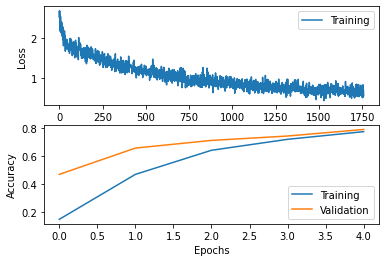

In [13]:
# plot loss and accuracy curves
def plot_loss_acc(train_loss, train_acc, val_loss, val_acc):   
    plt.subplot(2, 1, 1)
    plt.plot(train_loss)
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend(['Training'])

    plt.subplot(2, 1, 2)
    plt.plot(train_acc)
    plt.plot(val_acc)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Training', 'Validation'])
    
plot_loss_acc(overall_train_loss, overall_train_acc, overall_val_loss, overall_val_acc)

In [14]:
# test accuracy
test_stats = evaluate_ResNet(model, loader_test)

print('Final accuracy on test set: %f' % test_stats['accuracy_history'][-1])

Evaluating accuracies on test set
Got 98 / 128 correct (76.56)
Final accuracy on test set: 0.765625


In [15]:
def count_params(model):
   return sum([np.prod(p.size()) for p in model.parameters()])

In [16]:
count_params(model)

270410